# Simulation of biophysically detailed all-active model 

In [1]:
from allensdk.model.biophysical import runner
import json
import os
from argschema import ArgSchemaParser
from allensdk.api.queries.biophysical_api import BiophysicalApi
from allensdk.core.nwb_data_set import NwbDataSet
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set(style='whitegrid',font_scale=1.5)
plt.rcParams.update({'axes.grid':False})

### Define utility functions

In [2]:

def get_manifest_args(args):
    return runner.load_description(args)
    

def get_sweep_data(nwb_file,sweep_number):
    nwb = NwbDataSet(nwb_file)
    sweep = nwb.get_sweep(sweep_number)
    stim_diff = np.diff(sweep['stimulus']*1e12)
    stim_start = np.where(stim_diff != 0)[0][-2]
    stim_end = np.where(stim_diff != 0)[0][-1]
    
    # read v and t as numpy arrays
    v = sweep['response']*1e3
    dt = 1.0e3 / sweep['sampling_rate']
    num_samples = len(v)
    t = np.arange(num_samples) * dt
    return t,v,t[stim_start],t[stim_end]

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)
            

### Pick a cell and a sweep to run from the available set of protocols

In [3]:
            
cell_id = 468193142 # get this from the web site: http://celltypes.brain-map.org
sweep_num = 46 # Select a Long Square sweep :  1s DC


### Download all-active model

In [4]:
sdk_model_templates = {'all_active':491455321,'perisomatic':329230710}
bp = BiophysicalApi()
bp.cache_stimulus = True 
model_list = bp.get_neuronal_models(cell_id,model_type_ids=[sdk_model_templates['all_active']])
model_dict = model_list[0]

model_dir = 'all_active_models'
bp.cache_data(model_dict['id'], working_directory=model_dir) 
new_model_file = 'fit_parameters_new.json'
shutil.copyfile(new_model_file,os.path.join(model_dir,new_model_file))
copytree('modfiles',os.path.join(model_dir,'modfiles'))


2020-04-09 10:46:27,407 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/491317257
2020-04-09 10:47:18,192 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/491120157
2020-04-09 10:47:18,468 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/497615376
2020-04-09 10:47:18,524 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337019
2020-04-09 10:47:18,649 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337225
2020-04-09 10:47:18,723 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337054
2020-04-09 10:47:18,791 allensdk.api.api.retrieve_fi

### Running the legacy all-active models

In [5]:
os.chdir(model_dir)
os.system('nrnivmodl modfiles/')
manifest_file = 'manifest.json'
manifest_dict = json.load(open(manifest_file))

# sweeps by type is not populated when the model is downloaded using the api
# in that case add the sweep type to the manifest 
if 'sweeps_by_type' not in manifest_dict['runs'][0]:
    manifest_dict['runs'][0]['sweeps_by_type'] = {"Long Square":[sweep_num]}
json.dump(manifest_dict,open(manifest_file,'w'),indent=2) 

schema_legacy = dict(manifest_file=manifest_file)
runner.run(schema_legacy,procs=1,sweeps=[sweep_num])


Setting g_pas to 0.000115204 in soma
Setting e_pas to -60.8666 in soma
Setting g_pas to 0.00357173 in axon
Setting e_pas to -89.2642 in axon
Setting g_pas to 0.000734207 in apic
Setting e_pas to -85.0301 in apic
Setting g_pas to 0.000599527 in dend
Setting e_pas to -77.8017 in dend
Setting cm to 5.74988 in soma
Setting Ra to 80.4097 in soma
Setting cm to 6.40968 in axon
Setting Ra to 134.494 in axon
Setting cm to 1.661 in apic
Setting Ra to 134.795 in apic
Setting cm to 3.60089 in dend
Setting Ra to 132.962 in dend
Adding mechanism NaV to axon
Setting gbar_NaV to 0.00858067 in axon
Adding mechanism K_T to axon
Setting gbar_K_T to 0.00041204 in axon
Adding mechanism Kd to axon
Setting gbar_Kd to 0.00991589 in axon
Adding mechanism Kv2like to axon
Setting gbar_Kv2like to 0.028411 in axon
Adding mechanism Kv3_1 to axon
Setting gbar_Kv3_1 to 0.470895 in axon
Adding mechanism SK to axon
Setting gbar_SK to 0.00666493 in axon
Adding mechanism Ca_HVA to axon
Setting gbar_Ca_HVA to 2.26824e-05 

### Running the new all-active models

In [6]:

manifest_dict = json.load(open(manifest_file))

# Change the simulation output directory to avoid overwriting for the new models
for manifest_config in manifest_dict['manifest']:
    if manifest_config['key'] == 'WORKDIR':
        manifest_config['spec'] = 'work_new'

new_manifest_file = 'manifest_new.json' 
     
manifest_dict['biophys'][0]['model_file'] = [new_manifest_file,new_model_file]
json.dump(manifest_dict,open(new_manifest_file,'w'),indent=2)  

schema_new = dict(manifest_file=new_manifest_file, axon_type = 'stub')
runner.run(schema_new,procs=1,sweeps=[sweep_num])


Adding mechanism Im to dend
Setting gbar_Im to 0.00687448 in dend
Adding mechanism Ih to soma
Setting gbar_Ih to 1.66485e-05 in soma
Setting e_pas to -83.467 in dend
Setting cm to 5.11878 in axon
Adding mechanism CaDynamics to axon
Setting decay_CaDynamics to 914.34 in axon
Adding mechanism Ca_LVA to soma
Setting gbar_Ca_LVA to 0.00273242 in soma
Setting g_pas to 0.000173082 in axon
Adding mechanism Nap_Et2 to axon
Setting gbar_Nap_Et2 to 0.000296889 in axon
Setting Ra to 117.514 in apic
Adding mechanism CaDynamics to axon
Setting gamma_CaDynamics to 0.000502527 in axon
Adding mechanism NaTa_t to axon
Setting gbar_NaTa_t to 4.98663 in axon
Adding mechanism K_Tst to soma
Setting gbar_K_Tst to 0.0509156 in soma
Setting g_pas to 0.000173082 in apic
Adding mechanism Kv3_1 to apic
Setting gbar_Kv3_1 to 0.0188324 in apic
Adding mechanism Im to apic
Setting gbar_Im to 0.0048016 in apic
Adding mechanism CaDynamics to soma
Setting gamma_CaDynamics to 0.0281908 in soma
Setting cm to 3.72288 in s

### Comparing the responses

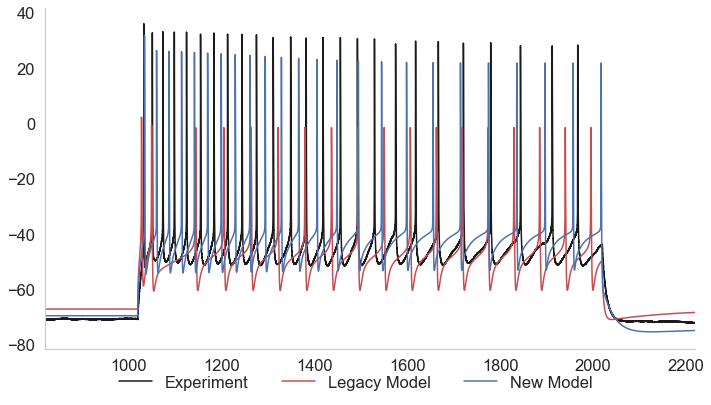

In [7]:

legacy_config = get_manifest_args(schema_legacy)
output_nwb_legacy = legacy_config.manifest.get_path('output_path')

new_config =  get_manifest_args(schema_new)
output_nwb_new = new_config.manifest.get_path('output_path')

exp_nwb = new_config.manifest.get_path('stimulus_path')

t_exp,v_exp,stim_start,stim_end = get_sweep_data(exp_nwb,sweep_num)
t_legacy_aa,v_legacy_aa,_,_ = get_sweep_data(output_nwb_legacy,sweep_num)
t_new_aa,v_new_aa,_,_ = get_sweep_data(output_nwb_new,sweep_num)

fig,ax = plt.subplots(figsize=(10,6))
ax.plot(t_exp,v_exp, color = 'k', label='Experiment')
ax.plot(t_legacy_aa,v_legacy_aa,color = 'r', label= 'Legacy Model')
ax.plot(t_new_aa,v_new_aa,color='b', label = 'New Model')
ax.set_xlim([stim_start-200,stim_end+200])
sns.despine(ax=ax)
h,l = ax.get_legend_handles_labels()
fig.legend(h,l,ncol=3,frameon=False,loc='lower center')
fig.tight_layout(rect=[0.0,0.05,1,0.95])

plt.show()
